In [1]:
import sys
from io import StringIO
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

In [2]:
sys.path.append('../src')

from utils import run_cmd

In [3]:
def calculate_each_position_depth(asm, raw, preset='map-ont', threads=8):
    if preset not in {'map-ont', 'ava-ont', 'asm5', 'sr'}:
        raise ValueError(f"Variable {preset} not support.")
    stdout, stderr = run_cmd(f"zcat -f {raw} | "\
                             f"minimap2 -t {threads} -K 8G -ax {preset} {asm} - | "\
                             f"samtools sort -@ {threads} --reference {asm} -O BAM - | "\
                             f"samtools depth -a -@ {threads} -")
    return stdout

def plot_each_position_depth(X, y, ax):
    mean = np.mean(y)
    std = np.std(y)
    low_cov = np.sum(y<5)
    ax.plot(X, y, label=f'mean depth :{mean:.2f}\n' + r'$\sigma$ :%.2f'%std + f'\ndepth < 5 :{low_cov}')
    ax.legend(frameon=True, shadow=True, fontsize=16, loc='upper left')
    ax.axhline(mean, color='r', ls='--', lw=2)

In [4]:
asm = '/media/GenomicResearch/Issue/20201221_hybrid_and_denovo/Unicycler/Contigs/R20-0030.fa'
raw = '/media/ONT/20211209_Lis/guppy_hac/barcode07/*'

In [5]:
result = calculate_each_position_depth(asm, raw, preset='map-ont', threads=24)

In [6]:
df = pd.read_csv(StringIO(result), sep='\t', header=None, usecols=[0, 1, 2], names=['contig_id', 'position', 'depth'])

(0.0, 1016.4)

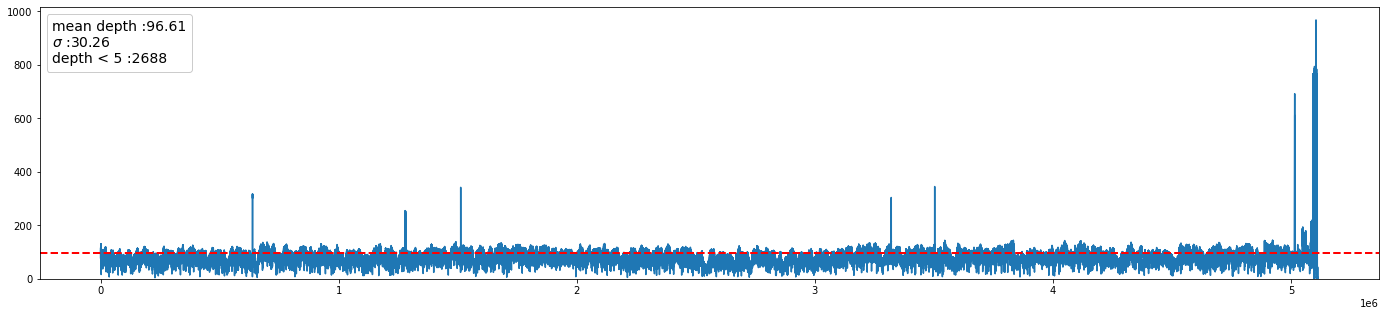

In [120]:
fig, ax = plt.subplots(figsize=(24, 5))
X = df.index
y = df['depth']
plot_each_position_depth(X, y, ax=ax)
legend = ax.legend(loc='upper left', fontsize=14, handlelength=0, handletextpad=0, fancybox=True, frameon=True, framealpha=1)
for item in legend.legendHandles:
    item.set_visible(False)
ax.set_ylim(0)

In [128]:
sum(df['depth']==0)

319

In [104]:
fig.savefig('/media/GenomicResearch/Issue/20210909_estimate_nanopore_depth/wga/20211223_Lis_WGA_barcode09/coverage.png', dpi=150, facecolor='w', bbox_inches='tight')

In [12]:
def cal_cov_and_depth(asm, raw, preset='map-ont', threads=8):
    if preset not in {'map-ont', 'ava-ont', 'asm5', 'sr'}:
        raise ValueError(f"Variable {preset} not support.")
    cmd = f"minimap2 -ax {preset} {asm} {raw} -t {threads} | "\
          f"samtools sort --threads {threads} -O BAM | "\
          f"samtools coverage --reference {asm} -q 7 -Q 30 -"
    stdout, stderr = run_cmd(cmd)
    return stdout

In [19]:
result = cal_cov_and_depth(
    '/media/GenomicResearch/Tools/amrfinder_database/latest/AMR_CDS',
    '/media/BioNumerics/NGS_Campylobacter/R16.1033_Rawreads_1.fastq.gz /media/BioNumerics/NGS_Campylobacter/R16.1033_Rawreads_2.fastq.gz',
    'sr',
    threads=16,
)

In [22]:
df = pd.read_csv(StringIO(result), sep='\t')

In [26]:
df = df[df['#rname'].str.contains('tet')]

In [33]:
df.sort_values('coverage', ascending=False)

#rname  startpos  endpos  \
41    488961139|WP_002872163.1|NG_048259.1|1|1|tet(O...         1    1920   
46    501919555|WP_012669445.1|NG_048264.1|1|1|tet(O...         1    1920   
51    695263665|WP_032490535.1|NG_048256.1|1|1|tet(O...         1    1920   
43    488999204|WP_002909882.1|NG_048263.1|1|1|tet(O...         1    1920   
58    915495706|WP_050824634.1|NG_048258.1|1|1|tet(O...         1    1920   
...                                                 ...       ...     ...   
548   1028100334|WP_063856469.1|NG_048312.1|1|1|tetA...         1    1725   
1932  1028223007|WP_063964002.1|NG_048170.1|1|1|tet(...         1    1206   
1943  1031994772|WP_064190967.1|NG_048311.1|1|1|tet(...         1    1251   
2143  1098480852|WP_071223302.1|NG_056049.1|1|1|tetB...         1     816   
6743  918672380|WP_052543100.1|NG_048302.1|1|1|tet(W...         1    1920   

      numreads  covbases  coverage  meandepth  meanbaseq  meanmapq  
41         567      1904   99.1667  73.287500       37.0      56.5  
46          18       987   51.4062   1.588020       36.8      39.8  
51          20       560   29.1667   1.650520       36.8      53.1  
43          22       531   27.6562   1.564580       36.5      39.3  
58           4       514   26.7708   0.273438       34.9      52.2  
...        ...       ...       ...        ...        ...       ...  
548          0         0    0.0000   0.000000        0.0       0.0  
1932         0         0    0.0000   0.000000        0.0       0.0  
1943         0         0    0.0000   0.000000        0.0       0.0  
2143         0         0    0.0000   0.000000        0.0       0.0  
6743         0         0    0.0000   0.000000        0.0       0.0  

[230 rows x 9 columns]

In [116]:
291851731/4800000

60.802443958333335